In [53]:
import tensorflow as tf

import numpy as np 
import cv2
import glob
from matplotlib import pyplot as plt
import os
import matplotlib.image as mpimg

In [215]:
# Hyper params
input_shape = (150, 150)
batch_size = 16
epochs = 8

# Model Building
- Begin with a simple cnn
- Transfer learning as a second step
- Finally use SOTA model such as effnet for trasnfer learning

In [3]:
def simple_cnn(input_shape=(150, 150, 3), num_classes=6):
    return tf.keras.Sequential([
        #  1st convolution
        tf.keras.layers.Conv2D(
            32, (3, 3), input_shape=input_shape, activation='relu', name='input_node'
        ),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # 2nd convolution
        tf.keras.layers.Conv2D(64, (3 ,3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3 ,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # FC Layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name='output_node')
    ])

# Data generator
- A data generator generates data in batches for the network to learn
- There are plenty of ways to use a generator
- Keras has in built default image data generator but
- Lets compare the type of generator which are:
    - Custom keras sequence
    - Raw data generator
    - Image datageneartor

# Keras default image generator

In [ ]:
# Lets start with keras default and move on from there
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(
    rescale=1/255.
)

In [ ]:
train_gen = image_gen.flow_from_directory(
    'data/seg_train/seg_train/', target_size=input_shape, 
    batch_size=batch_size, class_mode='categorical'
)

test_gen = image_gen.flow_from_directory(
    'data/seg_test/seg_test/', target_size=input_shape, 
    batch_size=batch_size, class_mode='categorical'
)

In [ ]:
history = cnn_model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    steps_per_epoch=train_gen.samples // batch_size
)

In [ ]:
cnn_model.evaluate_generator(test_gen)

# Generator without keras libs

In [137]:
label_map = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

In [128]:
def load_samples(image_dir):
    images_dir = glob.glob(image_dir + '*/*.jpg')
    samples = []
    
    for image_dir in images_dir:
        label = os.path.basename(os.path.dirname(image_dir))
        samples.append([
            image_dir, label_map[label]
        ])
    
    return samples

def preprocess_img(img, label, resize):
    img = cv2.resize(img, (resize, resize))
    img = img / 255
    label = tf.keras.utils.to_categorical(label, 6)
    return img, label

def image_generator(samples, batch_size=32, shuffle=True, resize=150):
    num_samples = len(samples)
    while True:
        # Shuffle every cycle
        if shuffle:
            np.random.shuffle(samples)
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset + batch_size]
            
            X_train = []
            y_train = []
            
            for batch_sample in batch_samples:
                image_name = batch_sample[0]
                label = batch_sample[1]
                
                img = cv2.imread(image_name)
                img, label = preprocess_img(img, label, resize)
                
                X_train.append(img)
                y_train.append(label)
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            
            yield X_train, y_train

In [134]:
train_samples = load_samples('data/seg_train/seg_train/')
test_samples = load_samples('data/seg_test/seg_test/')

train_generator = image_generator(train_samples, resize=224)
test_generator = image_generator(test_samples, resize=224)

In [133]:
cnn_model = simple_cnn(input_shape=(224, 224, 3))
cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_node (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 53, 53, 64)       

In [135]:
history = cnn_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_samples) // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 877 steps, validate for 187 steps
Epoch 1/20
877/877 [==============================] - 109s 124ms/step - loss: 1.0667 - accuracy: 0.5960 - val_loss: 0.8301 - val_accuracy: 0.7187
Epoch 2/20
877/877 [==============================] - 103s 117ms/step - loss: 0.7103 - accuracy: 0.7444 - val_loss: 0.6440 - val_accuracy: 0.7691
Epoch 3/20
877/877 [==============================] - 103s 117ms/step - loss: 0.5212 - accuracy: 0.8173 - val_loss: 0.6324 - val_accuracy: 0.7823
Epoch 4/20
877/877 [==============================] - 103s 117ms/step - loss: 0.3636 - accuracy: 0.8731 - val_loss: 0.5916 - val_accuracy: 0.7983
Epoch 5/20
877/877 [==============================] - 103s 118ms/step - loss: 0.2466 - accuracy: 0.9154 - val_loss: 0.6652 - val_accuracy: 0.7969
Epoch 6/20
877/877 [==============================] - 104s 118ms/step - loss: 0.1631 - accuracy: 0.9466 - val_loss: 0.7783 - val_accuracy: 0.7914
Epoch 7/20
877/877 [==========

KeyboardInterrupt: 

# Custom data generator keras

In [212]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, samples, 
        batch_size=32, input_shape=(150, 150),
        n_channels=3, n_classes=10, shuffle=True
    ):
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.samples = samples
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.samples) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        batch_samples = [self.samples[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(batch_samples)
        
        return X, y
   
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.samples))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_list):
        X = np.empty((self.batch_size, *self.input_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, batch_sample in enumerate(batch_list):
            image_path = batch_sample[0]
            label = batch_sample[1]
            
            img = cv2.imread(image_path)
            img = cv2.resize(img, self.input_shape)
            img = img / 255
            
            X[i, ] = img
            y[i] = label
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [194]:
def load_samples(image_dir):
    images_dir = glob.glob(image_dir + '*/*.jpg')
    samples = []
    
    for image_dir in images_dir:
        label = os.path.basename(os.path.dirname(image_dir))
        samples.append([
            image_dir, label_map[label]
        ])
    
    return samples

In [219]:
train_samples = load_samples('data/seg_train/seg_train/')
test_samples = load_samples('data/seg_test/seg_test/')

In [220]:
train_generator = DataGenerator(
    train_samples, batch_size=batch_size, input_shape=(224, 224), n_classes=6
)

test_generator = DataGenerator(
    test_samples, batch_size=batch_size, input_shape=(224, 224,), n_classes=6
)

In [204]:
cnn_model = simple_cnn(input_shape=(224, 224, 3))
cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_node (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 53, 53, 64)      

In [221]:
history = cnn_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_samples) // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 877 steps, validate for 187 steps
Epoch 1/8
877/877 [==============================] - 56s 64ms/step - loss: 0.2902 - accuracy: 0.8983 - val_loss: 0.6850 - val_accuracy: 0.7891
Epoch 2/8
877/877 [==============================] - 57s 64ms/step - loss: 0.2207 - accuracy: 0.9232 - val_loss: 0.7762 - val_accuracy: 0.7637
Epoch 3/8
877/877 [==============================] - 57s 65ms/step - loss: 0.1742 - accuracy: 0.9406 - val_loss: 0.7704 - val_accuracy: 0.7858
Epoch 4/8
877/877 [==============================] - 57s 65ms/step - loss: 0.1356 - accuracy: 0.9549 - val_loss: 0.8138 - val_accuracy: 0.7888
Epoch 5/8
877/877 [==============================] - 58s 66ms/step - loss: 0.1193 - accuracy: 0.9624 - val_loss: 0.8809 - val_accuracy: 0.7851
Epoch 6/8
877/877 [==============================] - 58s 66ms/step - loss: 0.1089 - accuracy: 0.9661 - val_loss: 0.9284 - val_accuracy: 0.7818
Epoch 7/8
877/877 [=============================

# Plot history

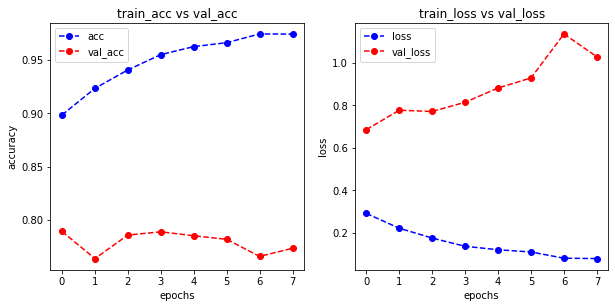

In [222]:
# Lets plot the history
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label='acc')
plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label='loss')
plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()

# Inference
- Lets just run some simple inferences just to test the accuracy

In [223]:
pred_images = glob.glob('data/seg_pred/seg_pred/*.jpg')
labels = [os.path.basename(folders) for folders in glob.glob('data/seg_train/seg_train/*')]

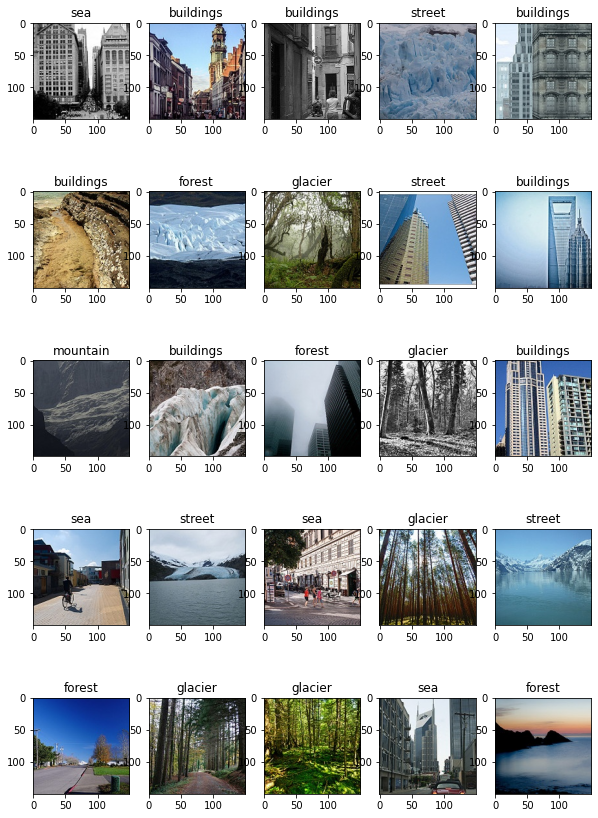

In [225]:
# prepare image for inference
np.random.shuffle(pred_images)

row = 5
column = 5
count = 0
plt.figure(figsize=(10, 15))

for pred_image in pred_images:
    img = cv2.imread(pred_image)
    img_copy = img.copy()
    img_copy = cv2.resize(img, (224, 224))
    img_copy = img_copy / 255.
    img_copy = np.expand_dims(img_copy, axis=0)

    preds = cnn_model.predict(img_copy)

    pred_max = np.argmax(preds)
    
    count += 1
    plt.subplot(row, column, count)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(labels[pred_max])
#     plt.tight_layout()
    if count == row * column:
        break